In [1]:
import numpy, cv2, time
from matplotlib import pyplot as plt
from matplotlib import cm
from JokeFunc import GrayImg
from importlib import reload
GrayImg = reload(GrayImg)

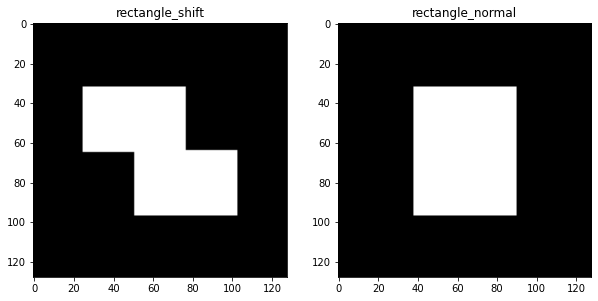

In [2]:
img_shape = (128,128)
height,width = img_shape[0], img_shape[1]
center = (img_shape[0]//2,img_shape[1]//2)
rectangle_shift = cv2.rectangle(numpy.zeros(img_shape),(width//5,height//4),(3*width//5,height//2),color=(255,255,255),thickness=-1)
rectangle_shift = cv2.rectangle(rectangle_shift,(2*width//5,height//2),(4*width//5,3*height//4),color=(255,255,255),thickness=-1)
rectangle_normal = cv2.rectangle(numpy.zeros(img_shape),(3*width//10,height//4),(7*width//10,3*height//4),color=(255,255,255),thickness=-1)

figure = plt.figure(figsize=(10,10))
figure.add_subplot(1,2,1)
plt.title('rectangle_shift')
plt.imshow(rectangle_shift,cmap='gray')
figure.add_subplot(1,2,2)
plt.title('rectangle_normal')
plt.imshow(rectangle_normal,cmap='gray')
plt.show()


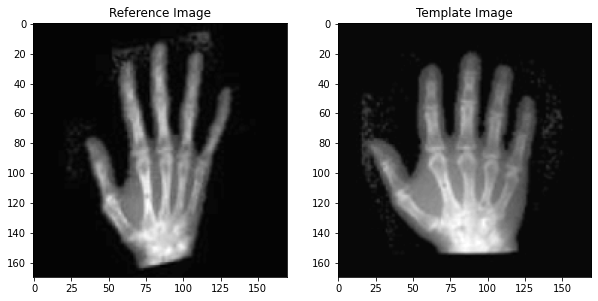

((170, 170), (170, 170))

In [3]:
hand_ref = cv2.imread(r'C:\Users\Admin\ImageRegistration\Image\R1.png',32)
hand_temp = cv2.imread(r'C:\Users\Admin\ImageRegistration\Image\T1.png',32)
hand_ref = hand_ref[:-1,:] 
hand_temp = hand_temp[:-1,:]
figure = plt.figure(figsize=(10,10))
figure.add_subplot(1,2,1)
plt.title('Reference Image')
plt.imshow(hand_ref,cmap='gray',vmax=255,vmin=0)
figure.add_subplot(1,2,2)
plt.title('Template Image')
plt.imshow(hand_temp,cmap='gray',vmax=255,vmin=0)
plt.show()
hand_ref.shape,hand_temp.shape

# Explicit Time Marching

rel_res = 1.0


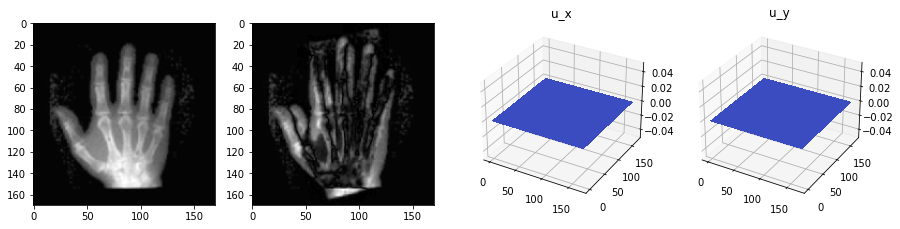

time = 31.216222047805786
iteration = 150 
diff =  0.13763315317567704
rel_res = 0.8213008950948727


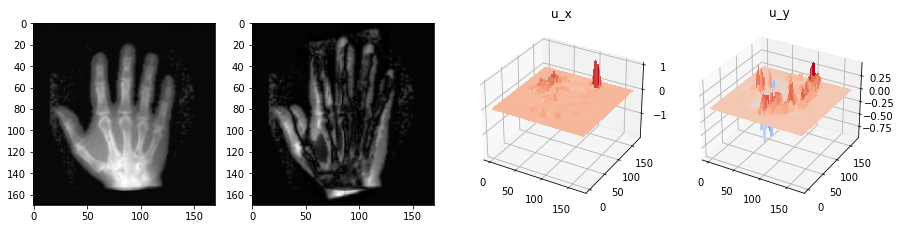

time = 25.59623694419861
iteration = 300 
diff =  0.136205185104494
rel_res = 0.8126560163836561


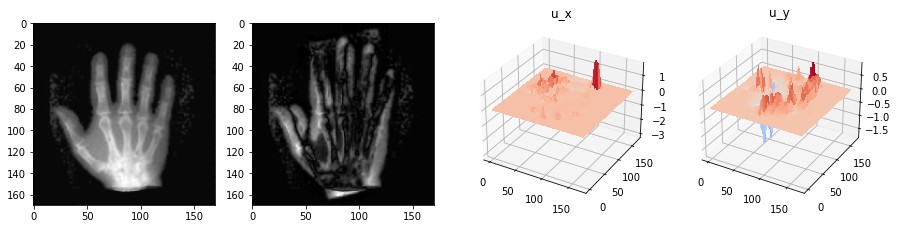

time = 25.253313779830933
iteration = 450 
diff =  0.137189801545766
rel_res = 0.8188050480447104


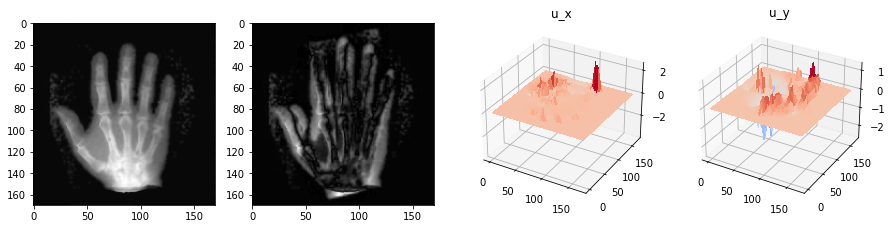

time = 31.666930437088013
iteration = 600 
diff =  0.13593775791262727
rel_res = 0.8116731253850954


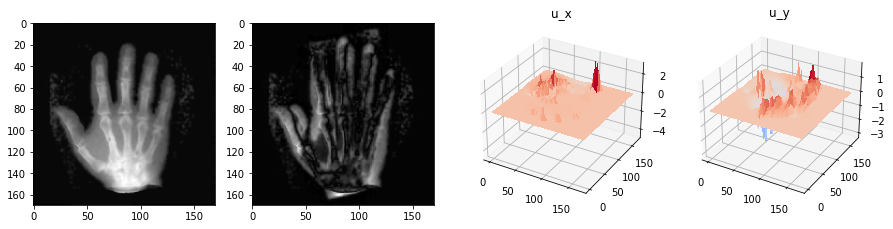

time = 32.66382598876953
iteration = 750 
diff =  0.13162988169113238
rel_res = 0.7852705556996411


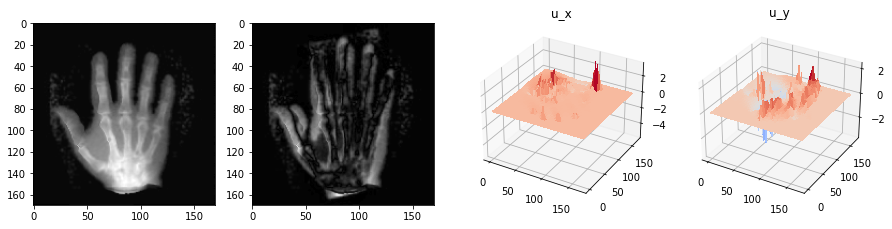

time = 32.310324907302856
iteration = 900 
diff =  0.1272226186051573
rel_res = 0.7588788174143108


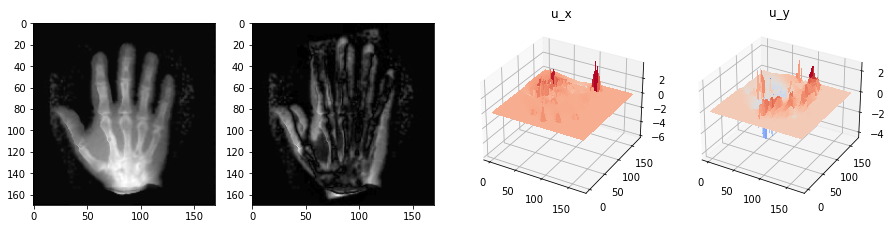

time = 32.57588195800781
iteration = 1050 
diff =  0.123146866706163
rel_res = 0.7351284195387169


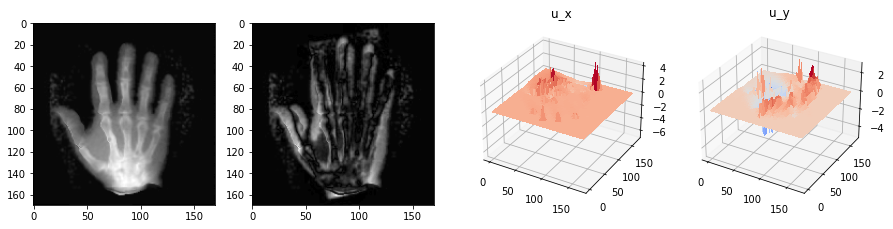

time = 32.45861029624939
iteration = 1200 
diff =  0.122973306199693
rel_res = 0.7338290288138027


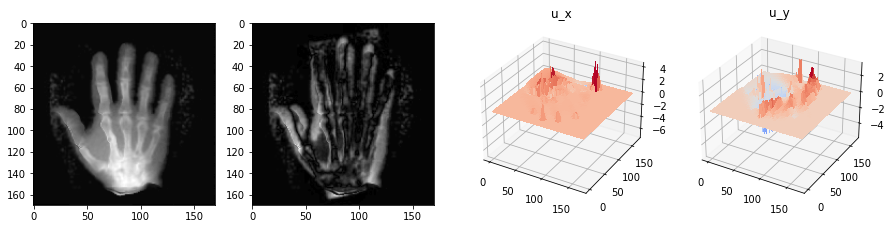

time = 32.563700914382935
iteration = 1350 
diff =  0.11522340155284481
rel_res = 0.687601783476177


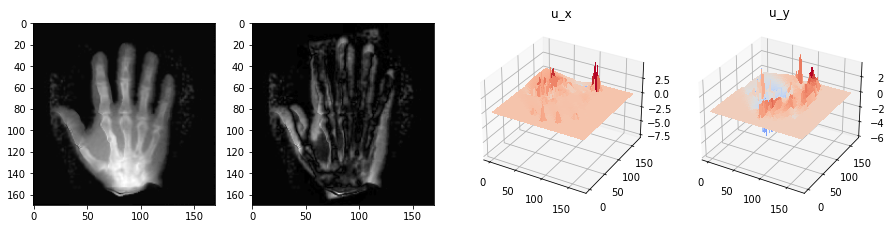

time = 32.80668783187866
iteration = 1500 
diff =  0.11442213335273266
rel_res = 0.6830913058818578


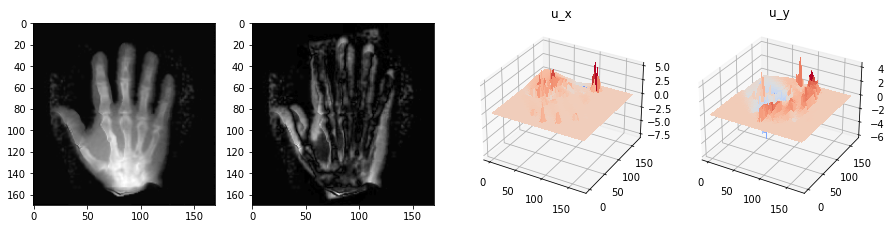

time = 30.19114899635315
iteration = 1650 
diff =  0.11342971311368283
rel_res = 0.676901739932749


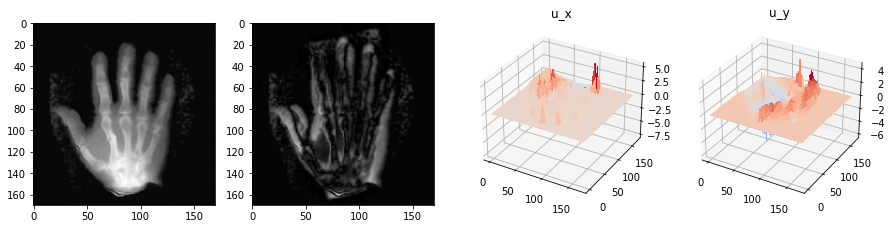

time = 25.17892837524414
iteration = 1800 
diff =  0.11029153728187137
rel_res = 0.6583694857673182


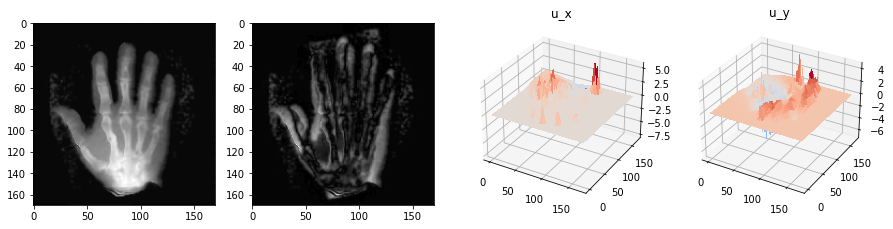

time = 25.25755786895752
iteration = 1950 
diff =  0.1072107493526069
rel_res = 0.6399952973120036


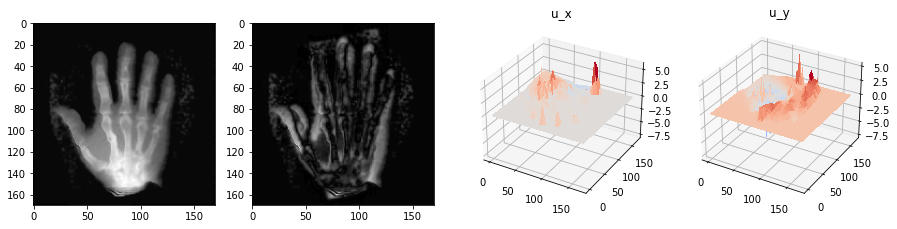

time = 27.67182469367981
iteration = 2100 
diff =  0.10684188589819144
rel_res = 0.6376643576833767


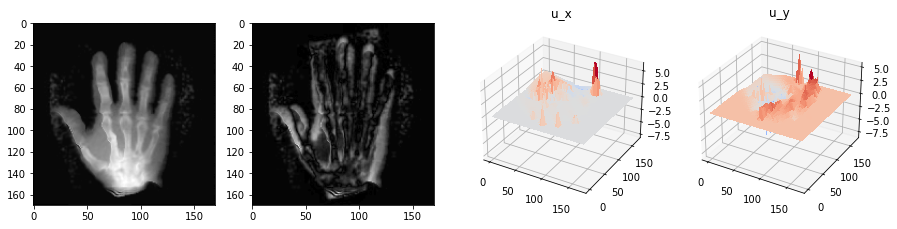

time = 32.47432827949524
iteration = 2250 
diff =  0.10372818906273396
rel_res = 0.619119789566185


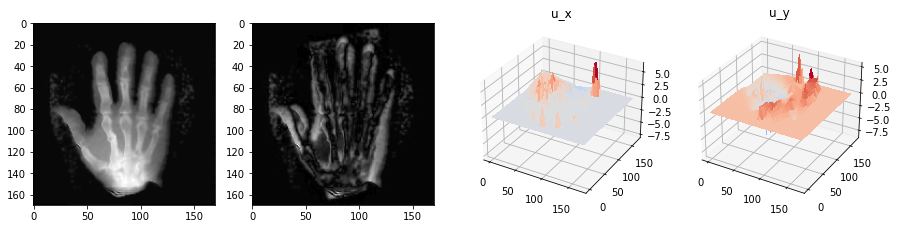

time = 32.335721492767334
iteration = 2400 
diff =  0.10213527998188683
rel_res = 0.6096405682658859


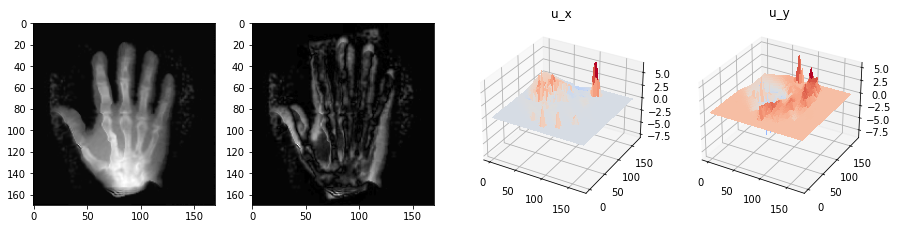

time = 25.884666204452515
iteration = 2550 
diff =  0.10023327919011327
rel_res = 0.598296834956767


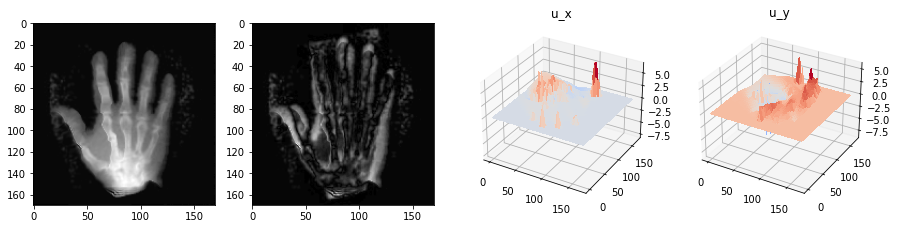

time = 25.012824296951294
iteration = 2700 
diff =  0.09778467028992885
rel_res = 0.5836775702123911


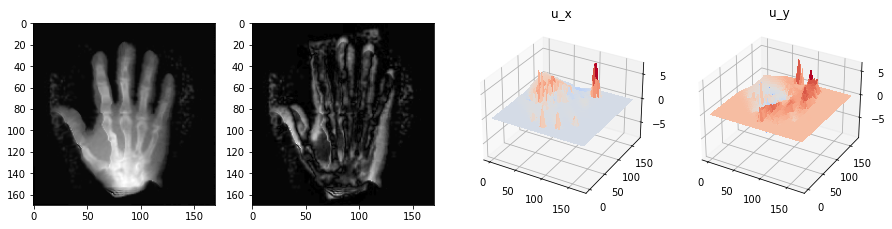

time = 25.280000686645508
iteration = 2850 
diff =  0.09900776997951052
rel_res = 0.5911396004443931


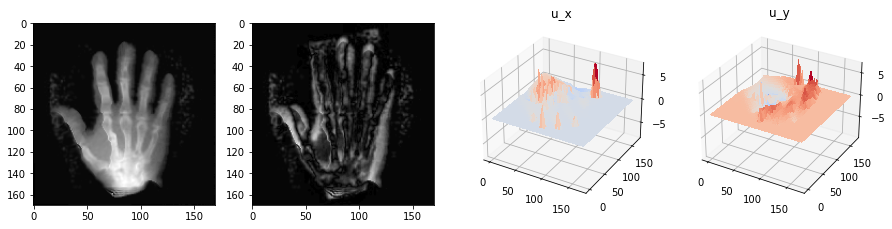

time = 25.405587673187256
iteration = 3000 
diff =  0.09804707089754161
Exceed


iteration = 3000 
diff =  0.09804707089754161 rel_res = 0.5852804420562103 total_time = 587.836950302124


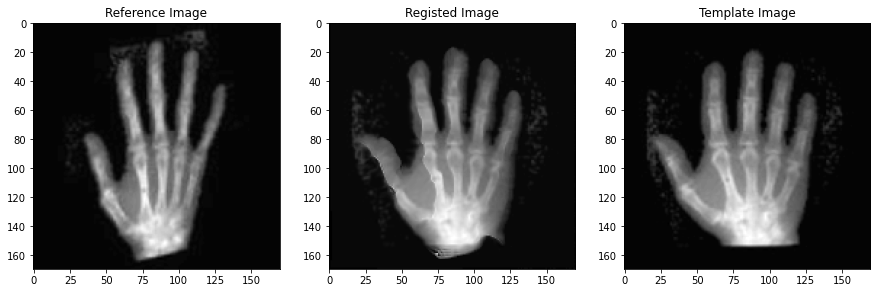

In [35]:
#ref_img = numpy.float32(circle_ref)/255
#ref_img = numpy.float32(rectangle_shift)/255
ref_img = numpy.float32(hand_ref)/255
#temp_img = numpy.float32(circle_temp)/255
#temp_img = numpy.float32(ellipse_temp)/255
#temp_img = numpy.float32(rectangle_normal)/255
temp_img = numpy.float32(hand_temp)/255

m,n = ref_img.shape
X = numpy.arange(0,m,1)
Y = numpy.arange(0,n,1)
X, Y = numpy.meshgrid(X, Y)

t1 = time.time()

Imax=3000
alpha=7e-3
beta =1e-4
tau=1e-1
res_eps=5e-2
diff_eps=1e-2

m, n = ref_img.shape
u = numpy.zeros((2,m,n))
res0_exist = False

for k in range(Imax):
    u_old = numpy.copy(u)
    
    #extended u by neuman BCs
    ex_u = numpy.zeros((2,m+2,n+2))
    ex_u[:,1:-1,1:-1] = u
    ex_u[:,0,1:-1] = u[:,0,:]
    ex_u[:,1:-1,0] = u[:,:,0]
    ex_u[:,-1,1:-1] = u[:,-1,:]
    ex_u[:,1:-1,-1] = u[:,:,-1]
    
    #grad.(grad(u)/norm(grad(u)))
    u_dx = ex_u[:,2:,1:-1]-u #forward
    u_dy = ex_u[:,1:-1,2:]-u #forward
    norm_gu = (u_dx**2+u_dy**2+beta)**0.5
    ux_gu = u_dx/norm_gu
    uy_gu = u_dy/norm_gu
    Kx = ux_gu-numpy.append(numpy.zeros((2,1,n)),ux_gu[:,:-1,:],1) #backward
    Ky = uy_gu-numpy.append(numpy.zeros((2,m,1)),ux_gu[:,:,:-1],2) #backward
    K = Kx+Ky
    
    ex_Tu = GrayImg.warp_vec(temp_img,ex_u,up=1,left=1,right=1,down=1)
    Tu = ex_Tu[1:-1,1:-1]
    Tu_dx = (ex_Tu[2:,1:-1]-ex_Tu[:-2,1:-1])/2 #central
    Tu_dy = (ex_Tu[1:-1,2:]-ex_Tu[1:-1,:-2])/2 #central
    Tu_du = numpy.zeros((2,m,n))
    Tu_du[0,:,:] = Tu_dx
    Tu_du[1,:,:] = Tu_dy
    
    Res = alpha*K-(Tu-ref_img)*Tu_du
    norm_Res = numpy.linalg.norm(Res)
    if not res0_exist:
        res0 = norm_Res
        res0_exist = True
        
    rel_res = norm_Res/res0
    
    regist_Diff_ETM_img = numpy.clip(Tu,0,255)
    Diff_regImg_refImg_img = abs(regist_Diff_ETM_img-ref_img)
    
    print_every = Imax//20
    if k%print_every==0:
        t3 = time.time()
        print('rel_res =',rel_res)
        #plt.imshow(Diff_regImg_refImg_img,cmap='gray')
        #plt.show()
        fig = plt.figure(figsize=(15,15))
        fig.add_subplot(1,4,1)
        plt.imshow(regist_Diff_ETM_img,cmap='gray')
        fig.add_subplot(1,4,2)
        plt.imshow(Diff_regImg_refImg_img,cmap='gray')
        u_x = fig.add_subplot(143,projection='3d')
        plt.title('u_x')
        u_x.plot_surface(X, Y, u[0,:,:], cmap=cm.coolwarm,linewidth=0, antialiased=False)
        u_y = fig.add_subplot(144,projection='3d')
        plt.title('u_y')
        u_y.plot_surface(X, Y, u[1,:,:], cmap=cm.coolwarm,linewidth=0, antialiased=False)
        plt.show()
        
    if rel_res<res_eps:
        print('solution converges')
        break

    #update u
    u = u+tau*Res
    
    diff = numpy.linalg.norm(u-u_old)
    if (k+1)%print_every==0:
        print('time =',time.time()-t3)
        print('iteration =',k+1,'\ndiff = ',diff)
    if diff<diff_eps:
        print('solution dose not change')
        break
        
if k==Imax-1:
    print('Exceed')
t2 = time.time()
print('\n\niteration =',k+1,'\ndiff = ',diff,'rel_res =',rel_res,'total_time =',t2-t1)
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,3,1)
plt.title('Reference Image')
plt.imshow(ref_img,cmap='gray')
fig.add_subplot(1,3,2)
plt.title('Registed Image')
plt.imshow(regist_Diff_ETM_img,cmap='gray')
fig.add_subplot(1,3,3)
plt.title('Template Image')
plt.imshow(temp_img,cmap='gray')
plt.show()